Stack Overflow questions

# Environment

In [136]:
import pandas as pd
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup as bs
import re
from wordcloud import WordCloud
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import TfidfModel
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel
from imp import reload

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Introduction

# Data extraction

The StackExchange data explorer can be use to extract information from the SQL database:
https://data.stackexchange.com/stackoverflow/query/new \
Information about the database schema can be found at:
https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

* We will extract the *Id*, *Title*, *Body*, and *Tags* from the *Posts* table
* We are working on questions, therefore, *TypeId* must be 1,
* We will generate 5 tags for each question, we therefore select posts with at least 5 *tags*,
* In order to select qualitative enouth posts, we select posts with a minimum *score* of 5,
* We order the extraction by *CreationDate*.

We used SQL request to obtain the .csv file from the *Exchange data explorer*:\
SELECT TOP(50000) Id, Title, Body, Tags\
From Posts\
WHERE PostTypeId = 1\
AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5\
AND Score >= 5\
ORDER BY CreationDate

In [117]:
df = pd.read_csv('QueryResults.csv',index_col=0)
df.head()

,Title,Body,Tags
Id,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>


# Data cleaning

* The database extraction contains html code, we remove it using the *BeautifulSoup* library:

In [147]:
lemmatizer = WordNetLemmatizer()

def extract_body(text):

    no_code = re.sub('<code>[^>]+</code>', '', text) # First, we remove the code citations, which is the text between the <code> tags
    text = bs(no_code).get_text() # Then, we remove all the HTML tags
    text = text.lower() # We convert the text to lower
    tokens = word_tokenize(text) # We tokenize the text
    tokens = list(set(tokens).difference(set(stopwords.words('english')))) # we remove the stopwords
    tags = nltk.pos_tag(tokens) # We generate the pos tags
    tokens = [token for token,pos in tags if pos in ['NN','NNP','NNS','NNPS','VB']]# # We select the target pos tags
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # We lemmatize the result

    return tokens
    

In [119]:
def extract_tags(text):

    stripped = text.strip('<').strip('>') # We remove the start and end '>' and '<'
    tokens = stripped.split('><') # We split the tags
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # We lemmatize the result

    return tokens

In [144]:
def extract_title(text):

    text = text.lower()
    tokens = word_tokenize(text)
    tokens = list(set(tokens).difference(set(stopwords.words('english'))))
    tags = nltk.pos_tag(tokens) # We generate the pos tags
    tokens = [token for token,pos in tags if pos in ['NN','NNP','NNS','NNPS','VB']]# # We select the target pos tags
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # We lemmatize the result
    
    return tokens

* We apply the tranformers on the datasets columns:

In [154]:
df['Body_tokens'] = df['Body'].apply(extract_body)
df['Tags_tokens'] = df['Tags'].apply(extract_tags)
df['Title_tokens'] = df['Title'].apply(extract_title)
df.head()

KeyboardInterrupt: 

# Data filtering

* In order to keep the most relevant informationb from the cleaned text, we make the following hypothesis:
    * A question about programming is usually about how to program with something (a technology) to do something (a result), or how to optimize the code to do something,
    * Therefore, the verbs and nouns must encapsulate most of the relevant information,
    * In opposition to sentiment analysis, the adverbs are not that relevant.
* We filter the cleaned text in order to keep the verbs and nouns:

In [121]:
def filter_body(cell):

    tokens = nltk.word_tokenize(cell) # We tokenize the words
    tags = nltk.pos_tag(tokens) # We generate the pos tags
    words = [word for word,pos in tags if pos in ['NN','NNP','NNS','NNPS']]#,'VB' # We select the target pos tags
    result = ','.join(words)

    return result

In [122]:
df['Body_filtered'] = df['Body_cleaned'].apply(filter_body)
df.head()

,Title,Body,Tags,Body_cleaned,Tags_cleaned,Body_filtered
Id,,,,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...,"opacity,tried,following,worked,application,fin...","c#,floating-point,type-conversion,double,decimal","opacity,application,fine,project,error,past,us..."
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,"day,hour,display,specific,given,value,time,ago...","c#,datetime,time,datediff,relative-time-span","day,hour,display,value,time,month"
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,"able,timezone,http,page,within,way,standard,we...","html,browser,timezone,user-agent,timezone-offset","timezone,http,page,way,standard,web,determine,..."
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,"obtain,bit,portable,script,challenge,involve,l...","performance,algorithm,language-agnostic,unix,pi","bit,script,challenge,involve,compare,time,test..."
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,"missing,discovered,c++,o,defined,error,tell,ru...","c++,c,sockets,mainframe,zos","c++,o,error,tell,rundown,time,matter,definitio..."


# Exploration

In [131]:
def gen_frequencies(series):

    dist = FreqDist(','.join(series).split(','))
    return dist

body_frequencies = gen_frequencies(df['Body_filtered'])

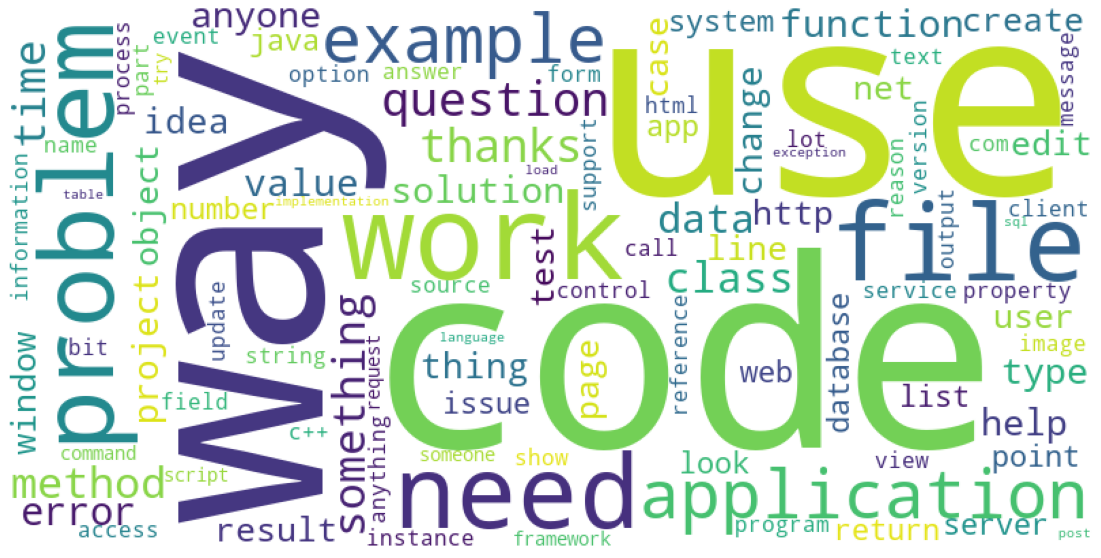

In [132]:
def word_cloud(frequencies):

    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 100,
        width=800,
        height=400).generate_from_frequencies(frequencies)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

word_cloud(body_frequencies)

In [125]:
def plot_frequencies(frequencies,name,top=10):

    dist_df = pd.DataFrame({'Tag':frequencies.keys(),'Frequency':frequencies.values()}).sort_values('Frequency').tail(top)
    fig = px.bar(dist_df,x='Frequency',y='Tag',orientation='h',title=f'Top {top} {name} frequencies',height=750)
    fig.show()

plot_frequencies(body_frequencies,'Body')

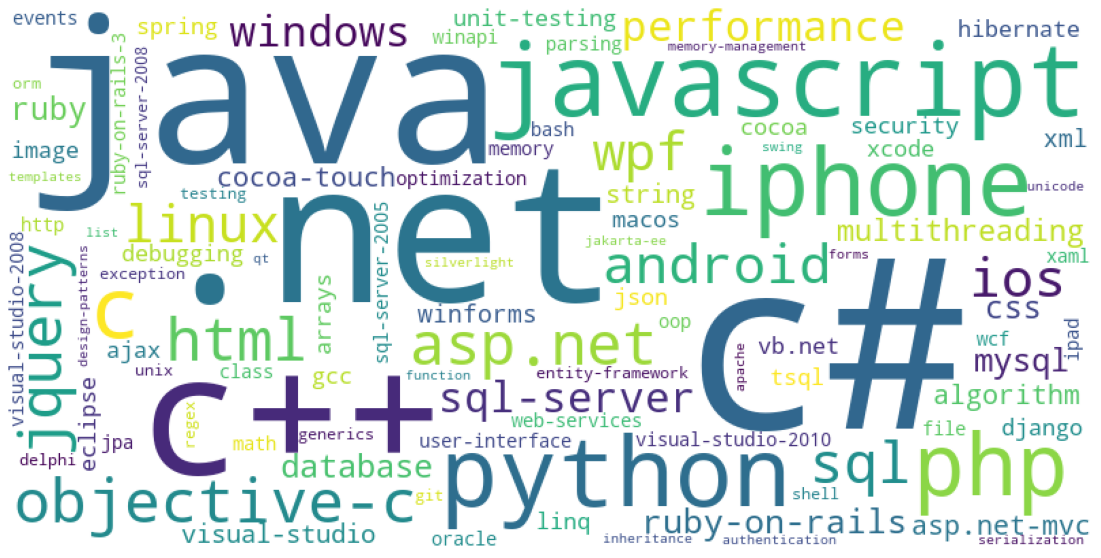

In [126]:
tags_frequencies = gen_frequencies(df['Tags_cleaned'])
word_cloud(tags_frequencies)

In [127]:
plot_frequencies(tags_frequencies,'Tags')

# LDA

* We create a dictionnary with the data and convert it to a bag of words corpus:

In [129]:
texts = df['Body_filtered'].str.split(',')
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = TfidfModel(corpus)
corpus = [tfidf[text] for text in corpus]

* We test various N topics in order to calculate the coherence and perplexity scores:

In [133]:
topics_range = list(range(1,31))
coherence_scores = list()
perplexity_scores = list()
lda_models = list()

for n_topics in topics_range:

    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=NUM_TOPICS,
        random_state=42,
        passes=10,
        workers=24
        )

    lda_models.append(lda_model)
    perplexity_scores.append(lda_model.log_perplexity(corpus))

    coherence_model = CoherenceModel(
        model=lda_model, 
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
        )

    coherence_scores.append(coherence_model.get_coherence())

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=topics_range, y=coherence_scores, name='Coherence'),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=topics_range, y=perplexity_scores, name='Perplexity'),
    secondary_y=True,
)
fig.update_layout(
    title_text=f"Scores per n topics"
)
fig.update_xaxes(title_text='n topics')
fig.update_yaxes(title_text="Coherence score", secondary_y=False)
fig.update_yaxes(title_text="Perplexity score", secondary_y=True)
fig.update_layout(height=600)
fig.show()

* We train the Gensim model:

In [ ]:
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.012*"time" + 0.011*"question" + 0.010*"use" + 0.009*"code"')
(1, '0.014*"http" + 0.013*"application" + 0.011*"use" + 0.011*"web"')
(2, '0.020*"class" + 0.016*"method" + 0.014*"way" + 0.014*"object"')
(3, '0.029*"file" + 0.014*"project" + 0.014*"run" + 0.014*"code"')
(4, '0.016*"work" + 0.014*"image" + 0.013*"code" + 0.013*"way"')


In [ ]:
model = LdaMulticore(corpus=corpus,
                            id2word=dictionary,
                            num_topics=NUM_TOPICS, 
                            random_state=42,
                            passes=10,
                            workers=24)

Saliency: a measure of how much the term tells you about the topic.
Relevance: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.
The size of the bubble measures the importance of the topics, relative to the data.
First, we got the most salient terms, means terms mostly tell us about what’s going on relative to the topics. We can also look at individual topic.

In [ ]:
lda_display = pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



When we have 5 or 10 topics, we can see certain topics are clustered together, this indicates the similarity between topics. What a a nice way to visualize what we have done thus far!

# Modelling

# Preprocessing

In [128]:
tfid_vectorizer = TfidfVectorizer(max_features=1000)
corpus = tfid_vectorizer.fit_transform(df['Body_filtered'])
topics = tfid_vectorizer.get_feature_names_out().tolist()
df_corpus = pd.DataFrame(
    data=corpus.toarray(),
    index=df.index,
    columns=topics
    )
df_corpus.head()

,ability,abstract,accept,access,account,act,action,activity,add,addition,...,wrapper,write,www,xaml,xcode,xml,xp,year,yield,zip
Id,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
